In [3]:
## Import libraries ##
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns
import pandas as pd

In [84]:
## Define functions ##

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()

def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo

# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(-5, 5, n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(var)
    
    return Xtest, mu, std

def plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    #Return mu and std:
    Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

## 4 Covariance Functions

- _Stationary_ covariance function is a function $x-x'$. It is invariant to translations in input space. Ex: squared exponential kernel.
- _Isotropic_ covariance function if it is a function of $\lvert x-x' \rvert$. Ex: squared exponential kernel.
- _Dot product_ covariance function if it depends only on $x$ and $x'$ through $x\cdot x'$. Ex: $k(x,x') = \sigma_0^2 + x\cdot x'$ from linear regression with $N(0,1)$ priors on the coefficients of $x_d$ and a prior of $N(0,\sigma_0^2)$ on the bias $1$. Another is the polynomail kernel $k(x,x') = (\sigma_0^2+x\cdot x')^p$. They're invariant to rotation of coordinates but not translations.
- _Gram matrix, or covariance matrix, K_ whose entries are $K_{ij} = k(x_i,x_j)$. It is a positive semidefinite matrix.

## 5 Model Selection and Adaptation of Hyperparameters

Families of covariance functions have _hyperparameters_ whose values we must determine. This is _model selection_. The _training_ of a GP is the process of selecting a covariance function's parameters.

### 5.4 Method 2: Marginal likelihood

Definitions
* _Likelihood_: let $p(x\vert \theta)$ be the density function of $x$ with a fixed $\theta$, and $x$ is a realization of the random variable $X$. The likelihood function $L(\theta\vert x) = p_\theta(x)$ is a fuction of $\theta$, the probability of $x$ for the parameter $\theta$. It is not a pdf. 
* _Maximum likelihood estimator (MLE)_: this is the value of $\theta$ that has the highest chance of obtaining sample $X$. That is, $\hat{\theta} = \text{argmax}_\theta L(\theta\vert x)$. If $\theta = (\theta_1,\theta_2)$, we can find $\hat{\theta} = (\hat{\theta_1},\hat{\theta_2})$ by solving $\frac{d}{d\theta_j}\ln(L(\theta\vert x))=0$.

In context of GPs:
* _Marginal likelihood (evidence)_: $p(y\vert X) = \int L(y\vert f,X)p(f\vert X) df$. Where the left integrand is the likelihood and the right is the pdf of the prior. Here, $f\vert X\sim N(0,K)$, $y\vert f \sim N(f,\sigma_n^2I)$, and $y\sim N(0,K+\sigma_n^2I)$ by property of marginal distribution of joint Normal (see definition of GP).
* We have $m$ hyperparameters $\theta = (\theta_1,\ldots,\theta_m)$ in our GP model based on observations $(X,y)$. Our goal is to maximize the marginal likelihood $p(y\vert X,\theta)$, where $\theta$ is unknown, based on the observed data $(X,y)$. That is, we want to find the _maximum marginal likelihood_
$$\hat{\theta} = \text{argmax}_\theta p(y\vert X,\theta)$$
Let's write $y\sim N(0,K+\sigma_n^2I) = N(0,K_y)$, where $K = k(X,X)$ and $K_y$ depends on $X,\theta$. Then,
$$p(y\vert X,\theta) = (2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y]$$
which we rewrite as the marginal log-likelihood
$$\ln(p(y\vert X,\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y.$$
We solve for $\hat{\theta} = \text{argmin}_\theta -\ln(p(y\vert X,\theta))$ with a gradient based optimization approach.

Sources used: Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 19, 115

_Objective function_: a function whose value is to be minimized or maximized.

_Gradient descent_: a method in optimization used for finding a local minimum of a differentiable multivariate function, like a cost or loss function in machine learning, by stepping in the direction of the gradient. Let $J(\theta) =  -\ln(p(y\vert X,\theta))$ be the objective function we want to minimize by updating $\theta$ in the oppositive direction of the gradient of $J(\theta)$, which we write as $\nabla_\theta J(\theta)$. Let $\eta$ determine the number of steps to reach the minimum, the learning rate.

Start with an initial parameter $\theta = \theta_1$. There are three gradient descent methods: 
* 1) _Batch gradient descent (vanilla update)_ computes the graident of the cost (objective) function with respect to $\theta$ for all the training observations $(X,Y)$
$$\theta_{i+1} = \theta_i - \eta\dot\nabla_{\theta_i} J(\theta_i)$$
* 2) _Stochastic gradient descent (SGD)_ updates $\theta_i$ by computing the gradient for only one randomly chosen data point $(x,y)$.
* 3) _Mini-batch SGD_ computes the gradient for a subset (mini-batch) of the dataset to find the gradient.

Sources used: https://arxiv.org/pdf/2205.00832.pdf, Ch. 2 Gradient Descent

Let's use a mini-batch SGD to train the hyperparameters $\theta$. Realistically, we don't have access to function values $f$ but only noisy versions $y_i = f(x_i) + \epsilon$ where $\epsilon \sim N(0,\sigma_n^2)$, $i=1,\ldots,n$. Unlike in the previous notebook where we defined the noise variance (observation variance) $\sigma_n^2$, here we treat it as one of the hyperparameters.

In [105]:
# Marginal log-likelihood of the GP we would like to optimize
def gp_loss_fn(par,X,y): #input observations (X,y) and initial parameters (guess)
    sigma_n, l, sigma = par #noise std, length scale l, and signal std
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll

#Test!
#try scipy minimize to find optimum parameters:
N = 7
X = np.random.uniform(-5, 5, size=(N,1))
y = (f(X) + np.random.normal(0,0.0005,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)
init_par = np.array([0.05,0.3,1])

sigma_n = 0, l = 2.2451, sigma_f = 1.0584


<Figure size 640x480 with 0 Axes>

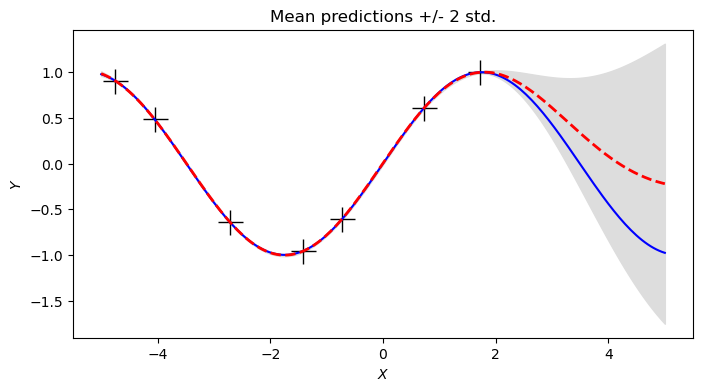

In [106]:
# Optimization method 1) L-BFGS-B
opt_par = minimize(gp_loss_fn, init_par,args=(X,y), method="L-BFGS-B", options = {'disp':True})
sigma_n, l, sigma = opt_par.x[0], opt_par.x[1], opt_par.x[2]
print("sigma_n = %i, l = %.4f, sigma_f = %.4f" % (sigma_n, l, sigma) )

y = y.T[0]
plot_post(X, y, sigma_n, l, sigma)